In [1]:
import os
try:
    from google.colab import drive
    drive.mount("/content/gdrive", force_remount=True)
    # cd gdrive/MyDrive/'Colab Notebooks'/Innovative-Approaches-to-Asset-Prediction/
    os.chdir("/content/gdrive/MyDrive/'Colab Notebooks'/Innovative-Approaches-to-Asset-Prediction/")
    print("Working on Google Colab...")
except:
    os.chdir(os.path.abspath(os.path.join(os.path.abspath(os.path.dirname(__vsc_ipynb_file__)), os.pardir)))
    print("Working on local machine...")

Working on local machine...


In [2]:
# !pip install -r requirements.txt

In [3]:
import torch
import random
import numpy as np
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
from livelossplot import PlotLosses

import seaborn as sns


In [4]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled = False
    return True

In [5]:
print(torch.version.cuda)

11.7


In [6]:
set_seed(42)

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available! Using CPU!")

Cuda installed! Running on GPU!


In [7]:
# Custom dataset to handle image and target loading
class ImageDataset(Dataset):
    def __init__(self, images, targets, transform=None):
        self.images = images
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]

        if self.transform:
            image = self.transform(image)

        return image, target

(3000, 2)
                                                   0    1
0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  1.0
1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ... -1.0
2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  1.0
3  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ... -1.0
4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ... -1.0


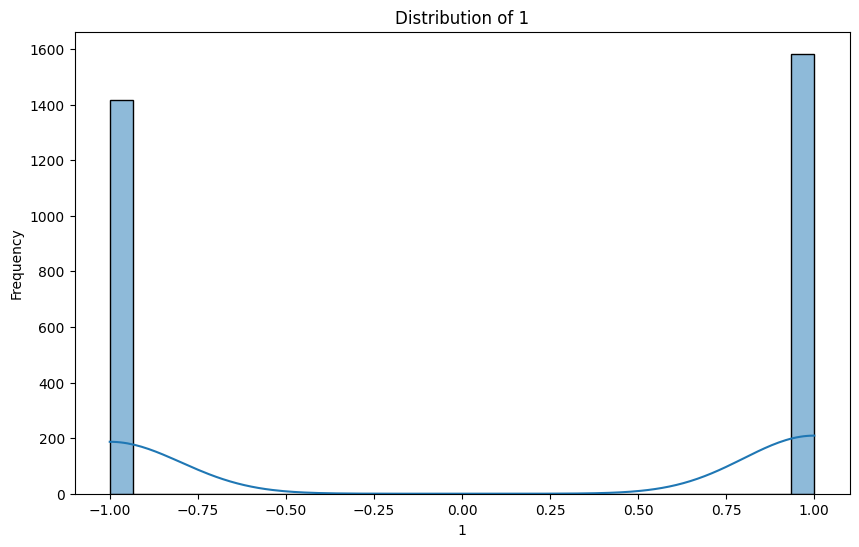

In [8]:
# Load the data
# full_data = np.load("./data/processed/SP500.EURUSD.USTREASURYINDEX.2014.2023/data.npy", allow_pickle=True)   # noqa
full_data = np.load("./data/processed/SP500.ASSET.ASSET.2000.2023/data.npy", allow_pickle=True)   # noqa

full_data = pd.DataFrame(full_data)


# full_data = full_data.head(3000)


print(full_data.shape)
print(full_data.head())
full_data.dropna(inplace=True)

# Plot the distribution of each column (except the image column)
for col in full_data.columns[1:]:
    plt.figure(figsize=(10, 6))
    sns.histplot(full_data[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [9]:
# data = full_data.head(200).to_numpy()
data = full_data.to_numpy()
print(data.shape)
# data = full_data[:500]
print(data[:1, :])

(2998, 2)
[[array([[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]], dtype=uint8) 1.0]]


In [10]:
def train_val_test_split(data, train_size=0.7, val_size=0.2):
    train_size = int(len(data) * train_size)
    val_size = int(len(data) * val_size)
    test_size = len(data) - train_size - val_size
    train_data = data[:train_size]
    val_data = data[train_size:train_size + val_size]
    test_data = data[train_size + val_size:]
    return train_data, val_data, test_data

In [11]:
train_data, val_data, test_data = train_val_test_split(data)

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

train_images = train_data[:, 0]
train_targets = np.asarray(train_data[:, 1:], dtype=np.float32)

val_images = val_data[:, 0]
val_targets = np.asarray(val_data[:, 1:], dtype=np.float32)

test_images = test_data[:, 0]
test_targets = np.asarray(test_data[:, 1:], dtype=np.float32)

(2098, 2)
(599, 2)
(301, 2)


In [12]:
from torchvision.transforms.functional import pad
from torchvision import transforms
from PIL import Image
import numpy as np
import numbers

def get_padding(image):    
    w, h = image.size
    max_wh = np.max([w, h])
    h_padding = (max_wh - w) / 2
    v_padding = (max_wh - h) / 2
    l_pad = h_padding if h_padding % 1 == 0 else h_padding+0.5
    t_pad = v_padding if v_padding % 1 == 0 else v_padding+0.5
    r_pad = h_padding if h_padding % 1 == 0 else h_padding-0.5
    b_pad = v_padding if v_padding % 1 == 0 else v_padding-0.5
    padding = (int(l_pad), int(t_pad), int(r_pad), int(b_pad))
    return padding

class SquarePad(object):
    def __init__(self, fill=0, padding_mode='constant'):
        assert isinstance(fill, (numbers.Number, str, tuple))
        assert padding_mode in ['constant', 'edge', 'reflect', 'symmetric']

        self.fill = fill
        self.padding_mode = padding_mode
        
    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be padded.

        Returns:
            PIL Image: Padded image.
        """
        img = Image.fromarray(img)
        return pad(img, get_padding(img), self.fill, self.padding_mode)
    
    def __repr__(self):
        return self.__class__.__name__ + '(padding={0}, fill={1}, padding_mode={2})'.\
            format(self.fill, self.padding_mode)

In [13]:
# Transformations for the images
transform = transforms.Compose([
    SquarePad(),  # Make the image square by padding
    transforms.Resize((64, 64)),  # Resize
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,)),  # Normalize to [-1, 1]
])

# Create datasets and dataloaders
trainset = ImageDataset(train_images, train_targets, transform=transform)
valset = ImageDataset(val_images, val_targets, transform=transform)
testset = ImageDataset(test_images, test_targets, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=1, shuffle=False)

In [14]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

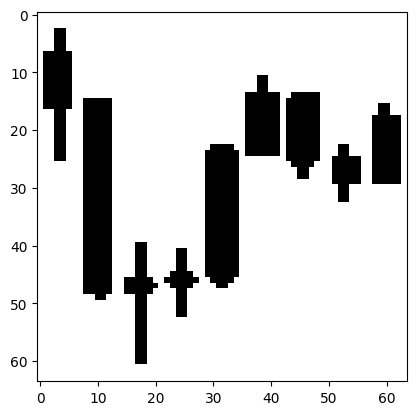

In [15]:
# get some random training images
images, labels = trainloader.dataset[0]

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

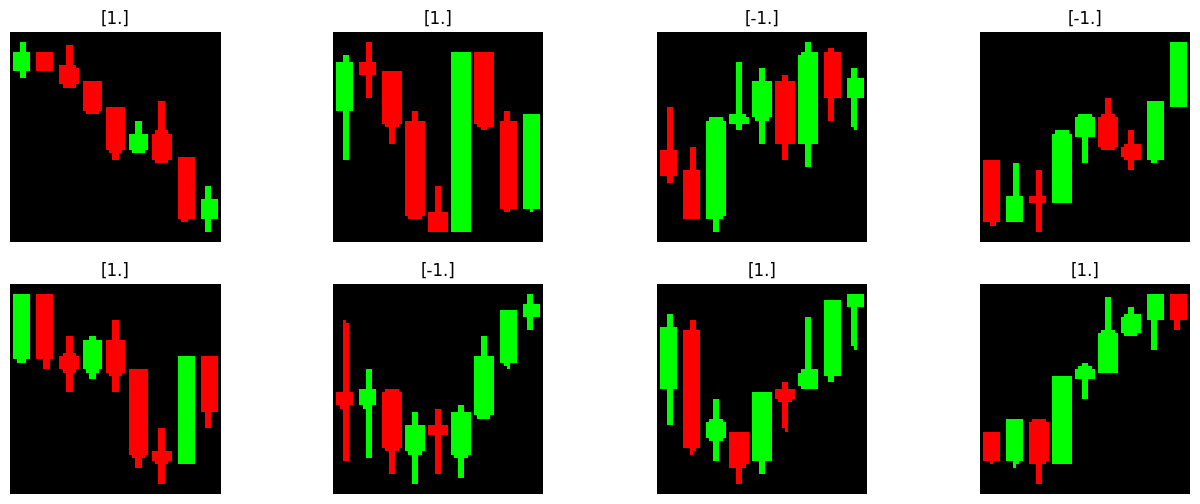

In [16]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainset.images, trainset.targets)

# plot images
plt.figure(figsize=(16, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(labels[i])
    plt.axis('off')
plt.show()

In [17]:
# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# Flexible Network with Residual Connections and Dropout
class FlexibleNet(nn.Module):
    def __init__(self, config):
        super(FlexibleNet, self).__init__()
        layers = []
        in_channels = config['in_channels']

        for out_channels, kernel_size, padding in config['conv_layers']:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(negative_slope=config['leak']))
            if out_channels > 128:  # Apply pooling only to higher dimension layers to avoid reducing spatial dimensions too quickly
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            in_channels = out_channels

        self.conv_layers = nn.Sequential(*layers)
        
        # Adding Residual Blocks
        self.residual_block1 = ResidualBlock(in_channels, in_channels)
        self.residual_block2 = ResidualBlock(in_channels, in_channels)
        
        self.flatten = nn.Flatten()
        
        # Calculate the size of the flattened features after all convolutions and pooling layers
        with torch.no_grad():
            self.feature_dim = self._calculate_feature_dim(config['img_size'], config['in_channels'])
        
        fc_layers = []
        input_dim = self.feature_dim
        for hidden_size in config['fc_layers']:
            fc_layers.append(nn.Linear(input_dim, hidden_size))
            fc_layers.append(nn.BatchNorm1d(hidden_size))
            fc_layers.append(nn.LeakyReLU(negative_slope=config['leak']))
            fc_layers.append(nn.Dropout(config['dropout']))
            input_dim = hidden_size

        fc_layers.append(nn.Linear(input_dim, config['output_size']))
        self.fc_layers = nn.Sequential(*fc_layers)

    def _calculate_feature_dim(self, img_size, in_channels):
        x = torch.randn(1, in_channels, *img_size)
        x = self.conv_layers(x)
        x = self.residual_block1(x)
        x = self.residual_block2(x)
        x = self.flatten(x)
        return x.shape[1]

    def forward(self, xb):
        xb = self.conv_layers(xb)
        xb = self.residual_block1(xb)
        xb = self.residual_block2(xb)
        xb = self.flatten(xb)
        xb = self.fc_layers(xb)
        xb = torch.tanh(xb)
        return xb

In [18]:
class PercentageDistanceLoss(nn.Module):
    def __init__(self, threshold=0.1):
        super(PercentageDistanceLoss, self).__init__()
        self.threshold = threshold

    def forward(self, outputs, targets):
        max_distance = 2.0
        distance = torch.abs(outputs - targets)
        percentage_distance = distance / max_distance

        # Calculate the mean percentage distance error
        mean_percentage_distance = torch.mean(percentage_distance)

        # Calculate the proportion of outputs within the threshold
        within_threshold = (distance <= self.threshold).float()
        proportion_within_threshold = len(within_threshold[within_threshold == 1]) / len(within_threshold)

        # Calculate the total loss as the mean percentage distance error
        # combined with the inverse proportion of outputs within the threshold
        total_loss = mean_percentage_distance + (1 - proportion_within_threshold)

        return total_loss, proportion_within_threshold

def rmse(pred, target):
    return torch.sqrt(torch.mean((pred - target) ** 2))

def print_examples(targets, predictions, num_examples=5):
    print("Samples (Target -> Prediction):")
    for i in range(num_examples):
        print(f"{targets[i]} -> {predictions[i]}")

In [19]:
# Initialize the model, loss function, optimizer, and scheduler
config = {
    'in_channels': 3,
    'conv_layers': [(32, 3, 1), (64, 3, 1), (128, 3, 1), (128, 3, 1), (256, 3, 1), (512, 3, 1), (512, 3, 1)],
    'fc_layers': [1024, 512],
    'leak': 0.2,
    'dropout': 0.5,
    'output_size': 1,
    'img_size': (64, 64)
}

model = FlexibleNet(config).to(device)

# Wrap the model with DataParallel to enable multi-GPU support
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

# Initialize the model, loss function, optimizer, and scheduler
model = FlexibleNet(config).to(device)
criterion = PercentageDistanceLoss(threshold=0.1)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
scaler = GradScaler()

Using 2 GPUs


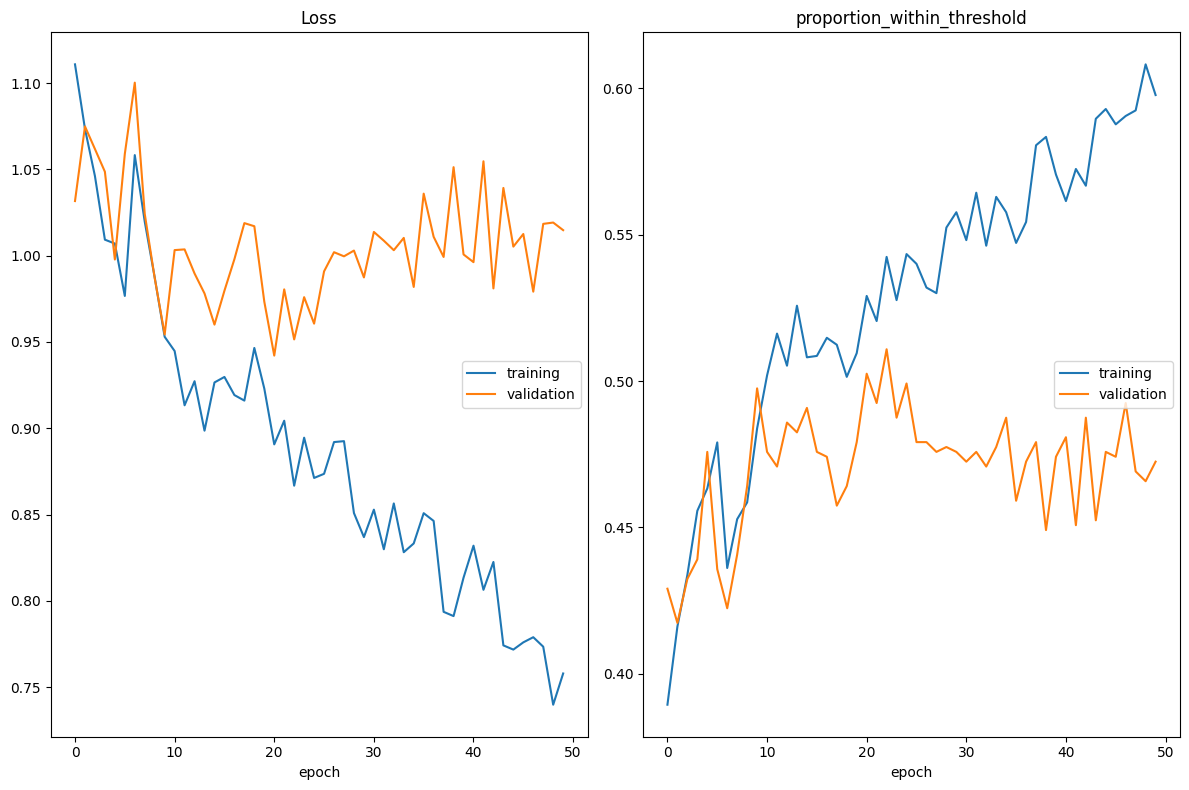

Epoch 50/50, Train Loss: 0.7579, Train Proportion: 0.5977, Validation Loss: 1.0148, Validation Proportion: 0.4725
Examples (Target -> Prediction):
[-1.] -> [-0.9985]
[1.] -> [1.]
[1.] -> [-1.]
[1.] -> [-1.]
[1.] -> [1.]
Finished Training


In [20]:
# Training loop
epochs = 500
best_val_loss = float('inf')
liveloss = PlotLosses(outputs=["MatplotlibPlot"])

for epoch in range(epochs):
    logs = {}
    model.train()
    running_loss = 0.0
    running_proportion = 0.0

    for images, targets in trainloader:
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss, proportion_within_threshold = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        running_proportion += proportion_within_threshold * images.size(0)

    train_loss = running_loss / len(trainloader.dataset)
    train_proportion = running_proportion / len(trainloader.dataset)
    logs['loss'] = train_loss
    logs['proportion_within_threshold'] = train_proportion

    # Validation
    model.eval()
    val_loss = 0.0
    val_proportion = 0.0
    val_targets = []
    val_predictions = []
    with torch.no_grad():
        for images, targets in valloader:
            images, targets = images.to(device), targets.to(device)
            with autocast():
                outputs = model(images)
                loss, proportion_within_threshold = criterion(outputs, targets)
            val_loss += loss.item() * images.size(0)
            val_proportion += proportion_within_threshold * images.size(0)
            val_targets.extend(targets.cpu().numpy())
            val_predictions.extend(outputs.cpu().numpy())

    val_loss = val_loss / len(valloader.dataset)
    val_proportion = val_proportion / len(valloader.dataset)
    logs['val_loss'] = val_loss
    logs['val_proportion_within_threshold'] = val_proportion

    liveloss.update(logs)
    liveloss.send()

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Proportion: {train_proportion:.4f}, Validation Loss: {val_loss:.4f}, Validation Proportion: {val_proportion:.4f}")

    # Print example predictions
    print_examples(val_targets, val_predictions, num_examples=5)

    # Save the model if it has the best validation loss so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), './deep_learning/models/best_model.pth')

    # Step the scheduler
    scheduler.step(val_loss)

print('Finished Training')

In [24]:
# Load the best model
model.load_state_dict(torch.load('./deep_learning/models/best_model.pth'))

# Test the model
model.eval()
test_loss = 0.0
test_rmse = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    for images, targets in testloader:
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)
        loss = criterion(outputs, targets)
        test_loss += loss[0].item() * images.size(0)
        test_rmse += rmse(outputs, targets).item() * images.size(0)
        all_predictions.append(outputs.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

test_loss = test_loss / len(testloader.dataset)
test_rmse = test_rmse / len(testloader.dataset)

# Concatenate all predictions and targets
all_predictions = np.concatenate(all_predictions)
all_targets = np.concatenate(all_targets)

# Display actual vs predicted values side by side
print("Actual vs Predicted:")
for actual, predicted in zip(all_targets, all_predictions):
    print(f"{str(list(actual))}\t\t  | {str(list(predicted))}")

# Display test loss and RMSE
print(f"Test Loss: {test_loss:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Actual vs Predicted:
[1.0]		  | [0.99999917]
[1.0]		  | [0.9985632]
[1.0]		  | [-1.0]
[1.0]		  | [-0.89985013]
[-1.0]		  | [-1.0]
[1.0]		  | [0.9996729]
[1.0]		  | [0.9999996]
[-1.0]		  | [-1.0]
[1.0]		  | [0.9894416]
[1.0]		  | [-0.9999999]
[1.0]		  | [-1.0]
[1.0]		  | [0.9992965]
[1.0]		  | [0.99994934]
[-1.0]		  | [-1.0]
[1.0]		  | [0.99970824]
[-1.0]		  | [0.99874246]
[1.0]		  | [0.9529647]
[1.0]		  | [0.992728]
[1.0]		  | [0.986868]
[1.0]		  | [-1.0]
[1.0]		  | [-0.6932967]
[-1.0]		  | [-0.996243]
[-1.0]		  | [-0.9999936]
[1.0]		  | [1.0]
[-1.0]		  | [-0.9986686]
[-1.0]		  | [-0.9991149]
[-1.0]		  | [-0.99999505]
[-1.0]		  | [-1.0]
[1.0]		  | [1.0]
[1.0]		  | [-0.9999999]
[1.0]		  | [-0.99999976]
[-1.0]		  | [0.999956]
[-1.0]		  | [1.0]
[1.0]		  | [0.8407277]
[-1.0]		  | [0.9996415]
[-1.0]		  | [0.9746596]
[-1.0]		  | [0.99999934]
[1.0]		  | [-0.7998224]
[1.0]		  | [-0.9999999]
[1.0]		  | [0.44165227]
[-1.0]		  | [-0.9993713]
[1.0]		  | [-0.9561754]
[1.0]		  | [-0.3241269]
[1.0]		